# Bioinfo Project 2023

In [187]:
#includes
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from prettytable import PrettyTable
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import umap
import numexpr as ne
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

# Step 1 - Data Preprocessing

## Gather RNA counts

To analyze the samples, you will need to merge them into a single Python object. One standard way to do this is to build a dataframe (or any "table like" struture) such as each row is "sample" and each column is a "gene". Make sure to test your dataset, so that if you change something later on, errors can be catch easily.

In [188]:
#Dataframe lines: customers, columns: genes
class SampleMerger:
    def __init__(self):          #constructor
        self.sample_files = None #files names
        self.df = None           #dataframe
    
    def __str__(self):           # print with str format
        if self.df is None:
            self.merge_samples()
        return str(self.df)
    
    #Getters
    def get_sample_files(self): #load files names
        if self.sample_files is None:
            self.set_sample_files()
        return self.sample_files
    
    def get_df(self):         #get the dataframe     
        if self.df is None:
            self.merge_samples()
        return self.df
    
    def get_sub_dataframe(self, columns): #get a sub dataframe
        if self.df is None:
            self.merge_samples()
        sub_df = self.df.loc[:, columns]
        return sub_df 
    
    #Setters
    def set_sample_files(self):  #load files names
        txt_files = []
        folder_path = '../Data/'

        for file_name in os.listdir(folder_path):
            if file_name.endswith('.txt'):
                txt_files.append(os.path.join(folder_path, file_name))
        self.sample_files = txt_files
    
    def merge_samples(self):
        """
        merge all the samples into one dataframe
        """

        count = 0
        i = 0
        j = -1
        gene_list = []
        nb_gene_list = [ [ None for y in range( len(self.sample_files) ) ]for x in range( 28953 ) ]
        
        for file in self.sample_files:
            j += 1
            with open(file) as fasta_file:
                for line in fasta_file:
                    line = line.strip()
                    if not(line.startswith("g")):
                        gene = line.split("\t")[0]
                        nb_gene = line.split("\t")[1]
                        if (count == 0):
                            gene_list.append(gene)
                        nb_gene_list[i][j] = int(nb_gene)
                        i += 1
            count = 1
            i = 0
        dictionnary = dict()
        for i in range (0, 28953):
            dictionnary[gene_list[i]] = nb_gene_list[i]
        self.df = pd.DataFrame(dictionnary)
        
        names = []
        for item in self.sample_files:
            name = item.split('/')[-1].split('.')[0]
            names.append(name)
        self.df.index = names
        
    #Step 2
    
    #Gen part
    
    def get_gen_mean_dict(self):
        """
        df: dataframe
        return the mean for each gene as a dictionary {key: gene; value: mean}
        """
        mean_dict = dict()
        for col in self.df.columns:
            mean_dict[col] = self.df[col].mean()
        return mean_dict

    def get_gen_median_dict(self):
        """
        df: dataframe
        return the median for each gene as a dictionary {key: gene; value: median}
        """
        median_dict = dict()
        for col in self.df.columns:
            median_dict[col] = self.df[col].median()
        return median_dict

    def get_gen_stdev_dict(self):
        """
        df: dataframe
        return the standard deviation for each gene as a dictionary {key: gene; value: standard deviation}
        """
        stdev_dict = dict()
        for col in self.df.columns:
            stdev_dict[col] = self.df[col].std()
        return stdev_dict    
    
    def plot_gen_mean(self):
        gene_means = dict(self.get_gen_mean_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Gene')
        plt.ylabel('Mean')
        plt.plot(gene_means)
        plt.title('Mean for each gene')
        
    def plot_gen_median(self):
        gene_means = dict(self.get_gen_median_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Gene')
        plt.ylabel('Median')
        plt.plot(gene_means)
        plt.title('Median for each gene')
    
    def plot_gen_std(self):   
        gene_means = dict(self.get_gen_stdev_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Gene')
        plt.ylabel('Standard Deviation')
        plt.plot(gene_means)
        plt.title('Standard deviation for each gene')
        
        
    #Sample part 
    
    def get_sample_mean_dict(self):
        """
        df: dataframe
        return the mean for each sample as a dictionary {key: gene; value: mean}
        """
        
        mean_dict = dict()
        row_means = self.df.mean(axis=1)
        for index, value in row_means.items():
            mean_dict[index] = value
        return mean_dict
        

    def get_sample_median_dict(self):
        """
        df: dataframe
        return the median for each sample as a dictionary {key: gene; value: median}
        """
        median_dict = dict()
        row_medians = self.df.median(axis=1)
        for index, value in row_medians.items():
            median_dict[index] = value
        return median_dict

    def get_sample_stdev_dict(self):
        """
        df: dataframe
        return the standard deviation for each sample as a dictionary {key: gene; value: standard deviation}
        """
        std_dict = dict()
        row_stds = self.df.std(axis=1)
        for index, value in row_stds.items():
            std_dict[index] = value
        return std_dict 
    
    def plot_sample_mean(self):
        gene_means = dict(self.get_sample_mean_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Sample')
        plt.ylabel('Mean')
        plt.plot(gene_means)
        plt.title("Samples mean")
        
    def plot_sample_median(self):
        gene_median = dict(self.get_sample_median_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Sample')
        plt.ylabel('Median')
        plt.plot(gene_median)
        plt.title("Samples median")    
    
    def plot_sample_std(self):   
        gene_std = dict(self.get_gen_stdev_dict()).values()
        plt.figure(figsize=(20,6))
        plt.xlabel('Sample')
        plt.ylabel('Standard Deviation')
        plt.plot(gene_std)
        plt.title("Samples standard deviation")
        

    #Variation Coefficient part
    
    def get_gen_cv_dict(self):
        """
        Retourne un dictionnaire contenant le coefficient de variation pour chaque gène.
        """
        cv_dict = dict()
        for col in self.df.columns:
            if self.df[col].mean() != 0:
                cv_dict[col] = self.df[col].std()/self.df[col].mean()
        return cv_dict
    
    def plot_gen_cv(self):
        gene_cv = list(dict(self.get_gen_cv_dict()).values())
        gene_cv.sort(reverse=True)
        plt.figure(figsize=(20,6))
        plt.xlabel('Gene')
        plt.ylabel('Coefficient of Variation')
        plt.bar(range(len(gene_cv)), gene_cv)
        plt.title("Coefficient of Variation for each gene")

    #PCA Methods
    
    def scale_data(self):
        """
        Center and scale the dataframe.
        """
        if self.df is None:
            self.merge_samples()
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.df)
        return scaled_data
    
    def perform_pca(self, n_components=None):
        """
        Perform PCA on the scaled dataframe and return the transformed data and the explained variance ratio.
        """
        scaled_data = self.scale_data()
        pca = PCA(n_components=n_components)
        transformed_data = pca.fit_transform(scaled_data)
        expl_variance_ratio = pca.explained_variance_ratio_
        return transformed_data, expl_variance_ratio
     
    def test_data(self): #tests
        if self.df is None:
            self.merge_samples()
        assert self.df.isnull().sum().sum() == 0, "There are missing values in the merged dataframe."
        assert isinstance(self.df, pd.DataFrame), "The merged object is not a dataframe."
        return True

In [189]:
Frame = SampleMerger()
Frame.set_sample_files()
Frame.merge_samples()


In [190]:
Frame.test_data()

True

In [191]:
Frame.get_df()

,"""A1BG""","""A1BG-AS1""","""A1CF""","""A2M""","""A2M-AS1""","""A2ML1""","""A2MP1""","""A3GALT2""","""A4GALT""","""A4GNT""",...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533311_CGND-HRA-00350_counts,27,89,0,1627,85,162,3,0,8,0,...,727,1414,1479,724,89,421,84,410,1199,1462
GSM3533394_CGND-HRA-01236_counts,62,175,0,3614,94,128,3,3,143,0,...,727,1863,1723,966,79,527,94,432,1679,1919
GSM3533310_CGND-HRA-00338_counts,29,88,0,1171,86,105,3,2,37,1,...,809,1790,1590,764,93,435,125,350,1579,1871
GSM3533352_CGND-HRA-00546_counts,16,133,0,1366,84,200,4,3,31,1,...,851,1738,1632,903,82,439,94,423,1704,1780
GSM3533279_CGND-HRA-00226_counts,38,83,0,2391,121,143,6,2,15,1,...,1095,2267,2122,1078,128,555,106,522,2087,2432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533344_CGND-HRA-00436_counts,17,43,4,900,73,113,1,2,6,1,...,727,1561,1372,702,83,350,99,351,1256,1479
GSM3533334_CGND-HRA-00409_counts,48,127,0,1635,105,226,1,1,24,0,...,465,1006,1087,519,48,329,86,277,789,905
GSM3533391_CGND-HRA-01219_counts,37,118,0,1245,104,168,1,1,21,1,...,847,1822,1625,903,96,472,120,415,1556,1768
GSM3533263_CGND-HRA-00209_counts,30,63,0,1024,34,56,1,0,9,0,...,288,640,644,352,30,179,46,136,614,723


## Gather sample annotations

The sample annotations are all placed in a unique "xml" file. First, open the file with any text editor, and try to understand its architecture. Then, identify the information that could be relevant for your analysis.

Finally, create a dataframe (or any "table like" structure) such as each row is a samples and each column an annotation. Make sur to test your dataset (gene counts+annotations) so that you can catch any error in the next steps.

In [192]:
class SampleAnnotation:
    def __init__(self):          #constructor
        self.df = None           #dataframe
        
    def get_df(self):
        return self.df  
    
    def collect_annotations(self):
        # Reading the XML file
        url = '{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}'
        tree = ET.parse('../Data/GSE124439_family.xml')
        root = tree.getroot()

        # List to store annotation data

        data_list = []

        # Loop to loop through samples and extract other annotations

        for sample in root.findall(url+'Sample'):

            #Sample ID retrieval

            #print(sample)
            sample_id = sample.get('iid')


            # Recovery of annotations

            annotations = {}
            for i in sample.findall(url+'Channel'):
                for charac in i.findall(url+'Characteristics'):


                    if charac.get('tag') in ['cns subregion', 'subject id', 'sample group']:

                        annotations[charac.get('tag')] = charac.text.strip()

            # Add data to list

            data = {'sample_id': sample_id, **annotations}
            data_list.append(data)

        # Creating the DataFrame from the data

        self.df = pd.DataFrame(data_list)  
    
    def represent_sample_groups(self):
        counts = self.df['sample group'].value_counts(normalize=True) * 100

        # Créer un diagramme camembert
        plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=['red', 'blue', 'green'])
        plt.title('Répartition des sujets par catégorie')
        plt.show()

    def represent_cns_subregion(self):
        counts = self.df['cns subregion'].value_counts(normalize=True) * 100

        # Créer un diagramme camembert
        plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=['red', 'blue', 'green', 'yellow'])
        plt.title('Répartition des sujets par catégorie')
        plt.show()

    def __str__(self):
        if self.df is None:
            self.collect_annotations()
            
        return str(self.df)
    
    def get_sub_dataframe(self, columns):
        if self.df is None:
            self.merge_samples()
        sub_df = self.df.loc[:, columns]
        return sub_df 

In [193]:
Annotations = SampleAnnotation()
Annotations.collect_annotations()
Annotations.df.head()

,sample_id,cns subregion,subject id,sample group
0,GSM3533230,Frontal Cortex,NEUEL133AK6,ALS Spectrum MND
1,GSM3533231,Frontal Cortex,NEUYV496XLP,ALS Spectrum MND
2,GSM3533232,Frontal Cortex,NEUZU200WEQ,ALS Spectrum MND
3,GSM3533233,Frontal Cortex,NEUME287RK2,ALS Spectrum MND
4,GSM3533234,Frontal Cortex,NEUEC006FND,ALS Spectrum MND


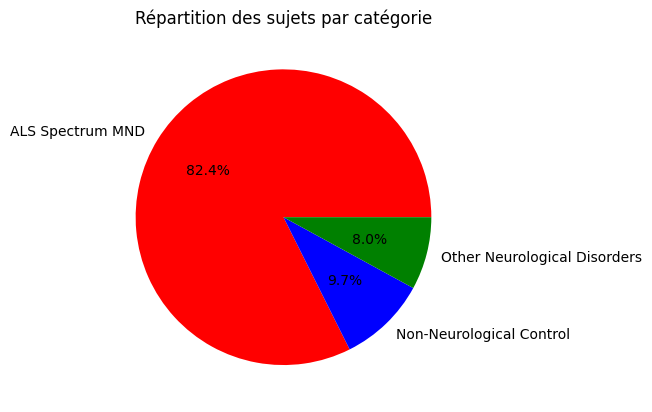

In [194]:
Annotations.represent_sample_groups()

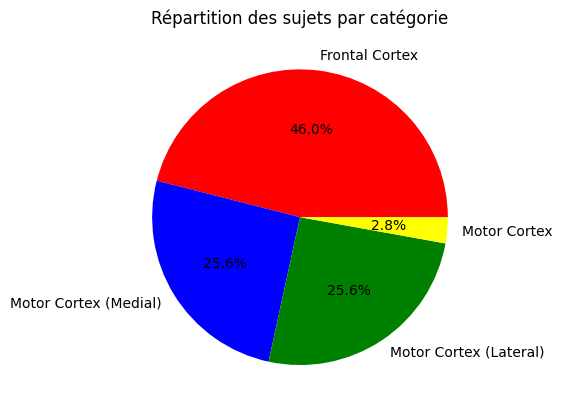

In [195]:
Annotations.represent_cns_subregion()

# Step 2 - Descriptive analysis

## RNA counts description:

For each gene, compute the mean, the median and the standard deviation

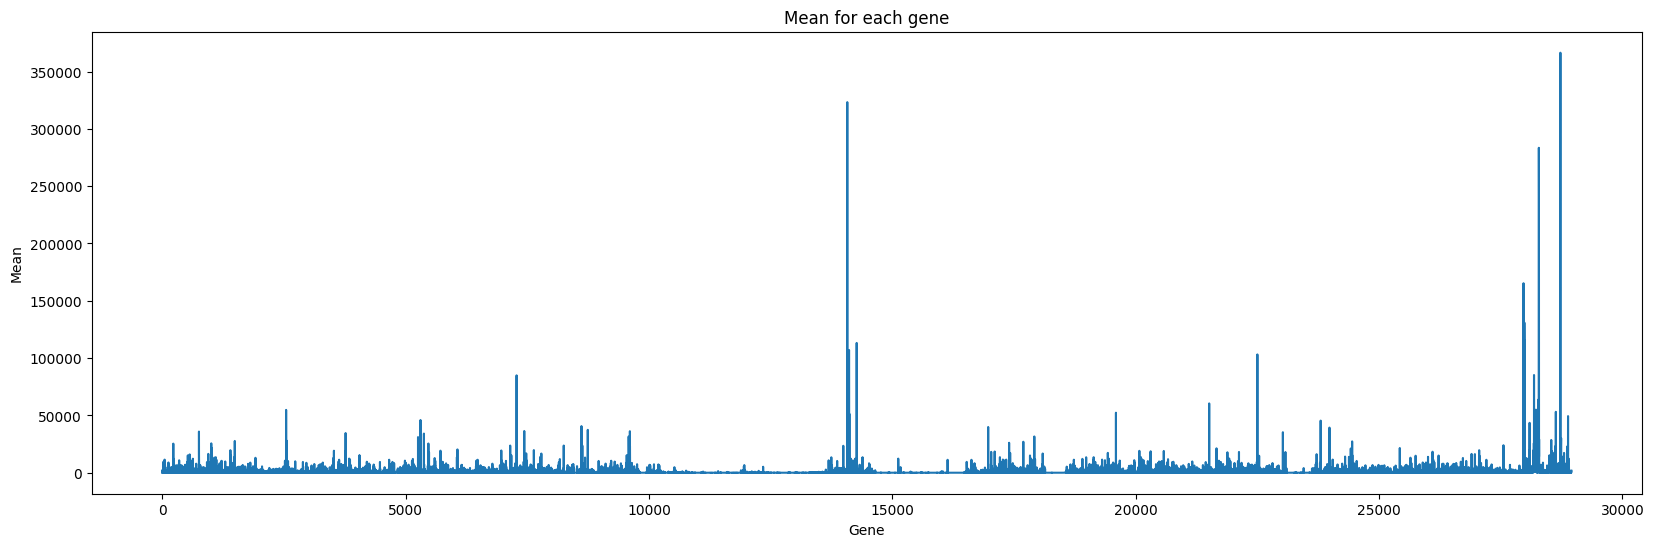

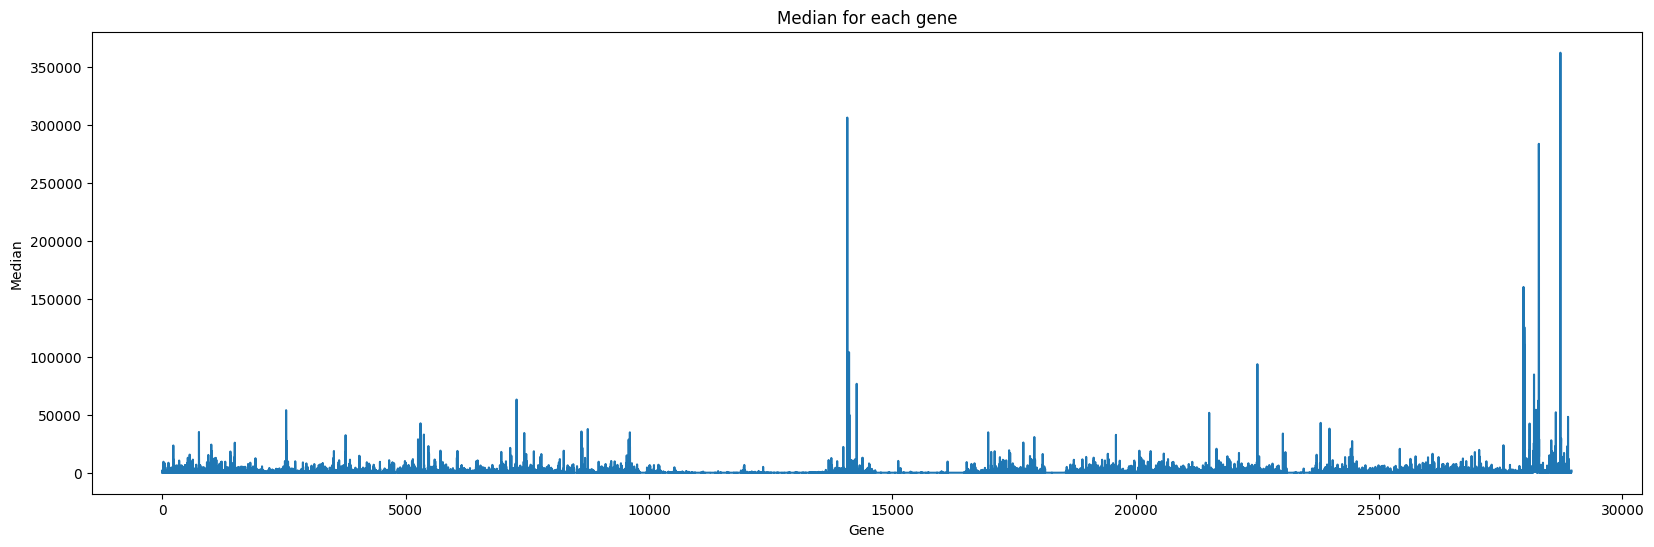

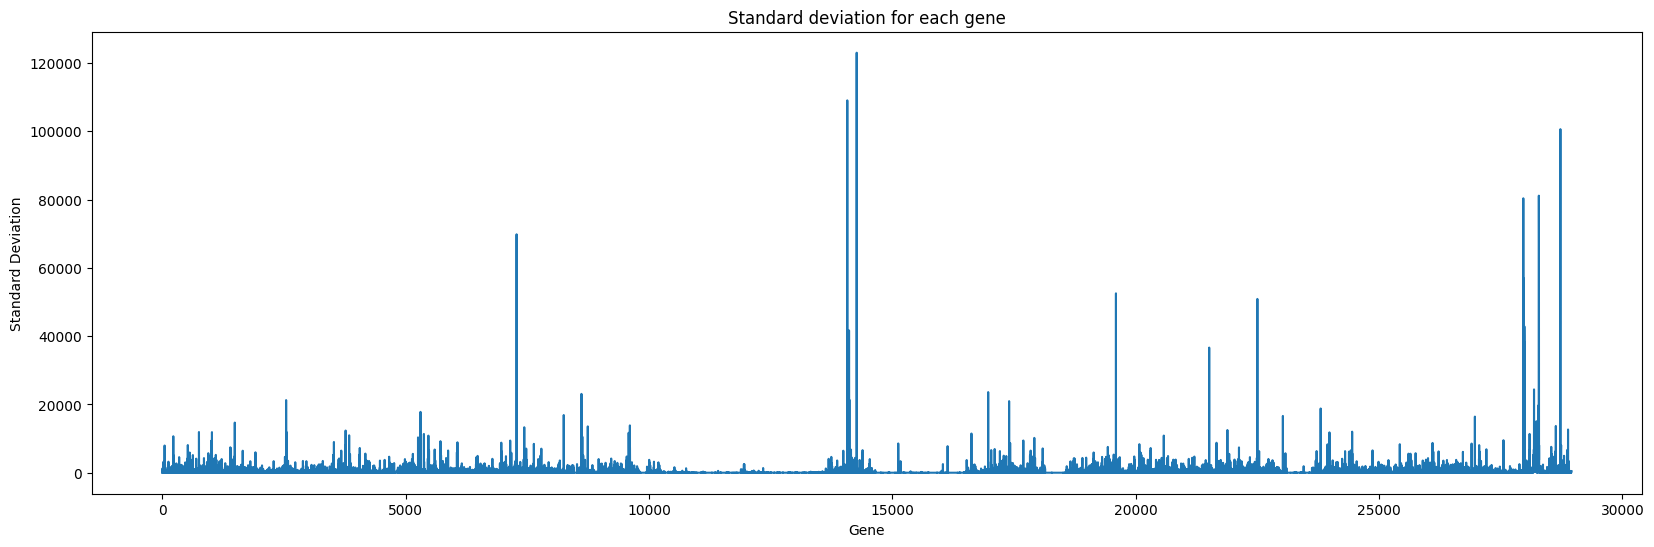

In [196]:
Frame.plot_gen_mean()
Frame.plot_gen_median()
Frame.plot_gen_std()


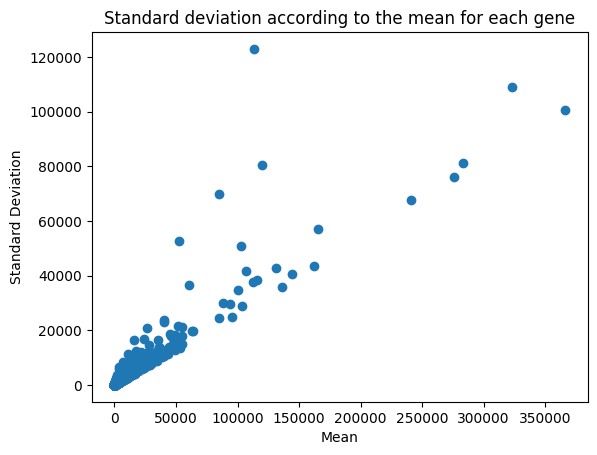

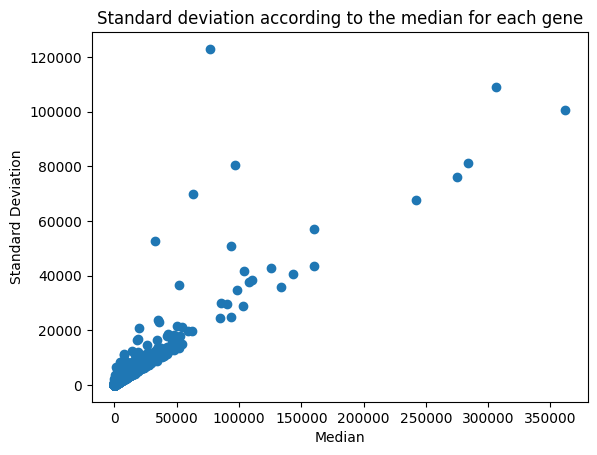

In [197]:
#Representing standard deviation according to the mean and median (for genes)

gen_mean_dict = Frame.get_gen_mean_dict()
gen_median_dict = Frame.get_gen_median_dict()
gen_stdev_dict = Frame.get_gen_stdev_dict()

plt.scatter(x = gen_mean_dict.values(), y = gen_stdev_dict.values())
plt.title("Standard deviation according to the mean for each gene")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

plt.scatter(x = gen_median_dict.values(), y = gen_stdev_dict.values())
plt.title("Standard deviation according to the median for each gene")
plt.xlabel("Median")
plt.ylabel("Standard Deviation")
plt.show()

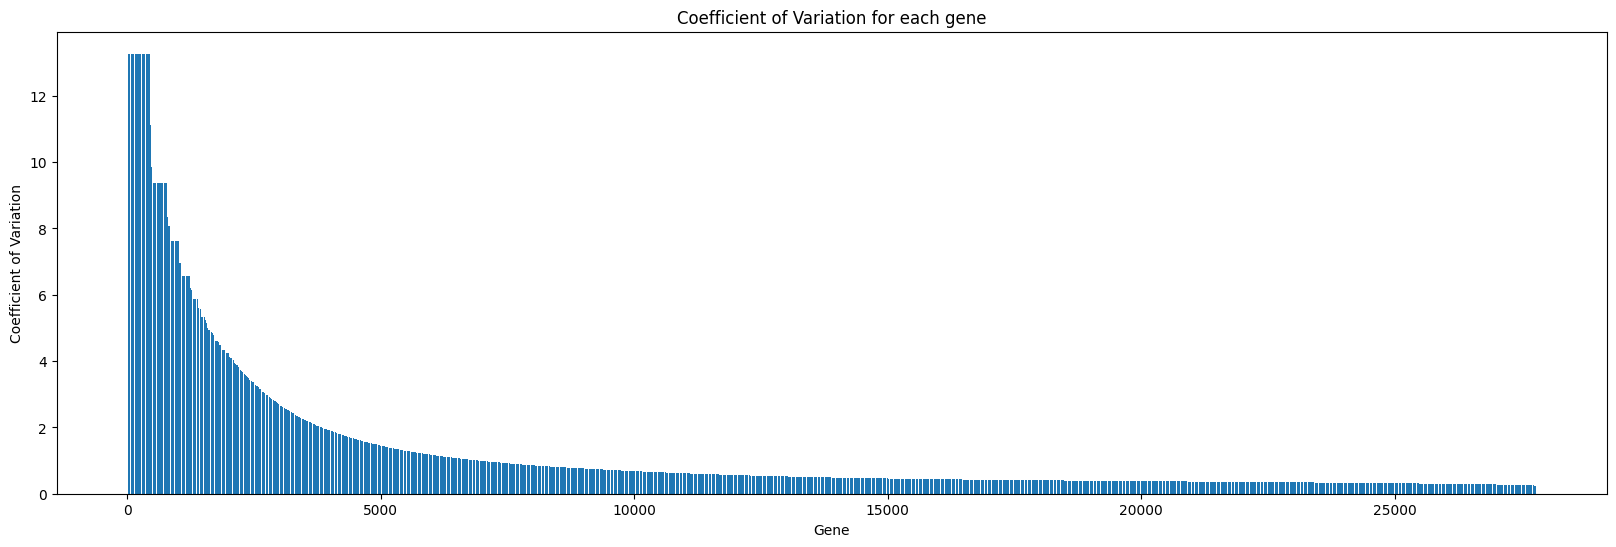

In [198]:
# Representing Variation Coefficient

Frame.plot_gen_cv()


## Samples description:

For each sample, compute the mean (across all genes), the median, the standard deviation. Find a way to efficiently report all those data. As for the RNA counts, think about which subsets you can analyse.



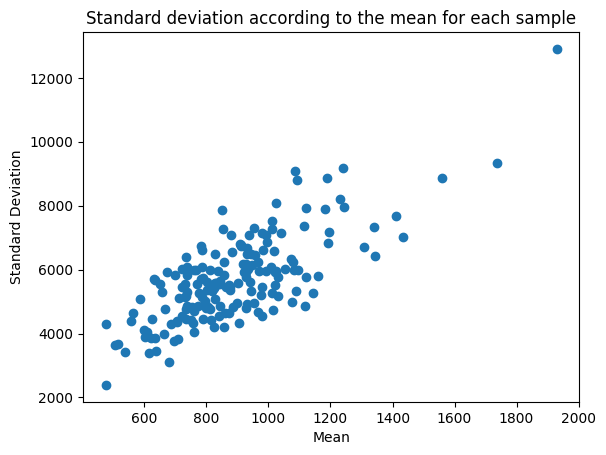

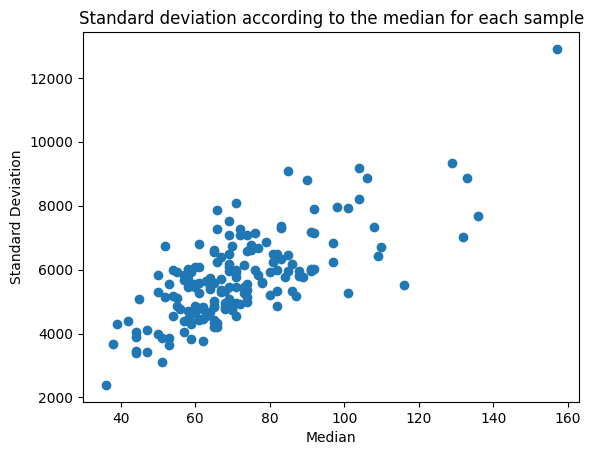

In [199]:
#Representing standard deviation according to the mean and median (for samples)

sam_mean_dict = Frame.get_sample_mean_dict()
sam_median_dict = Frame.get_sample_median_dict()
sam_stdev_dict = Frame.get_sample_stdev_dict()

plt.scatter(x = sam_mean_dict.values(), y = sam_stdev_dict.values())
plt.title("Standard deviation according to the mean for each sample")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

plt.scatter(x = sam_median_dict.values(), y = sam_stdev_dict.values())
plt.title("Standard deviation according to the median for each sample")
plt.xlabel("Median")
plt.ylabel("Standard Deviation")
plt.show()

# Step 3: PCA

38.78471565062957


<BarContainer object of 2 artists>

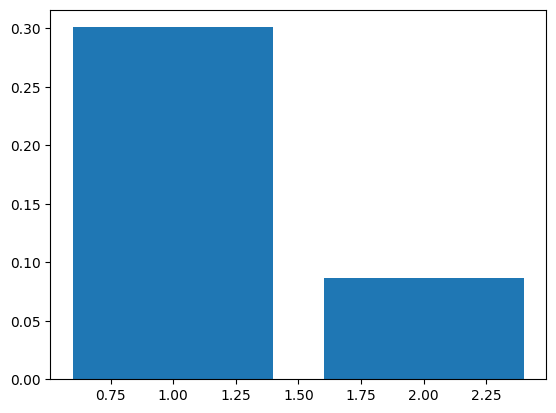

In [200]:
n_components=2
scaled_data = Frame.scale_data()
transformed_data, expl_variance_ratio = Frame.perform_pca(n_components)
print(sum(expl_variance_ratio*100))
plt.bar(np.arange(1,n_components+1), expl_variance_ratio)


62.88620549642736


<BarContainer object of 10 artists>

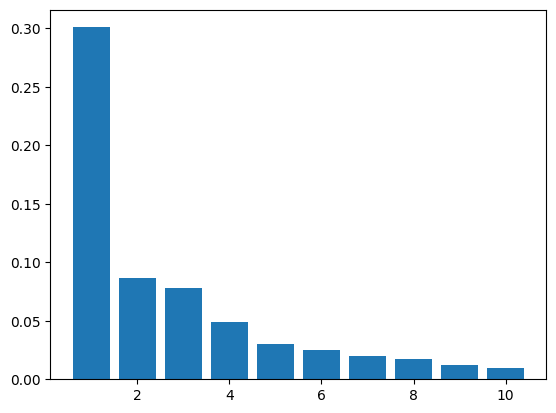

In [201]:
n_components = 10
scaled_data = Frame.scale_data()
transformed_data, expl_variance_ratio = Frame.perform_pca(n_components)
print(sum(expl_variance_ratio*100))
plt.bar(np.arange(1,n_components+1), expl_variance_ratio)

79.74474182244157


<BarContainer object of 50 artists>

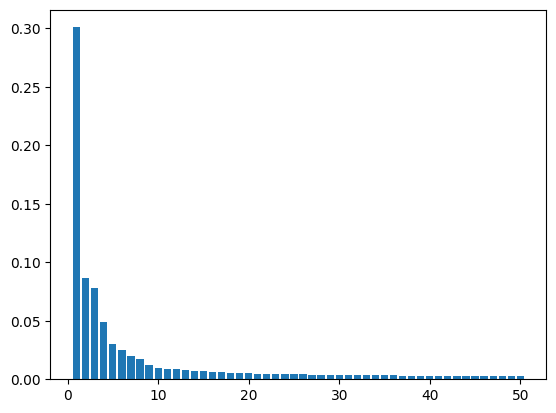

In [202]:
n_components = 50
scaled_data = Frame.scale_data()
transformed_data, expl_variance_ratio = Frame.perform_pca(n_components)
print(sum(expl_variance_ratio*100))
plt.bar(np.arange(1,n_components+1), expl_variance_ratio)

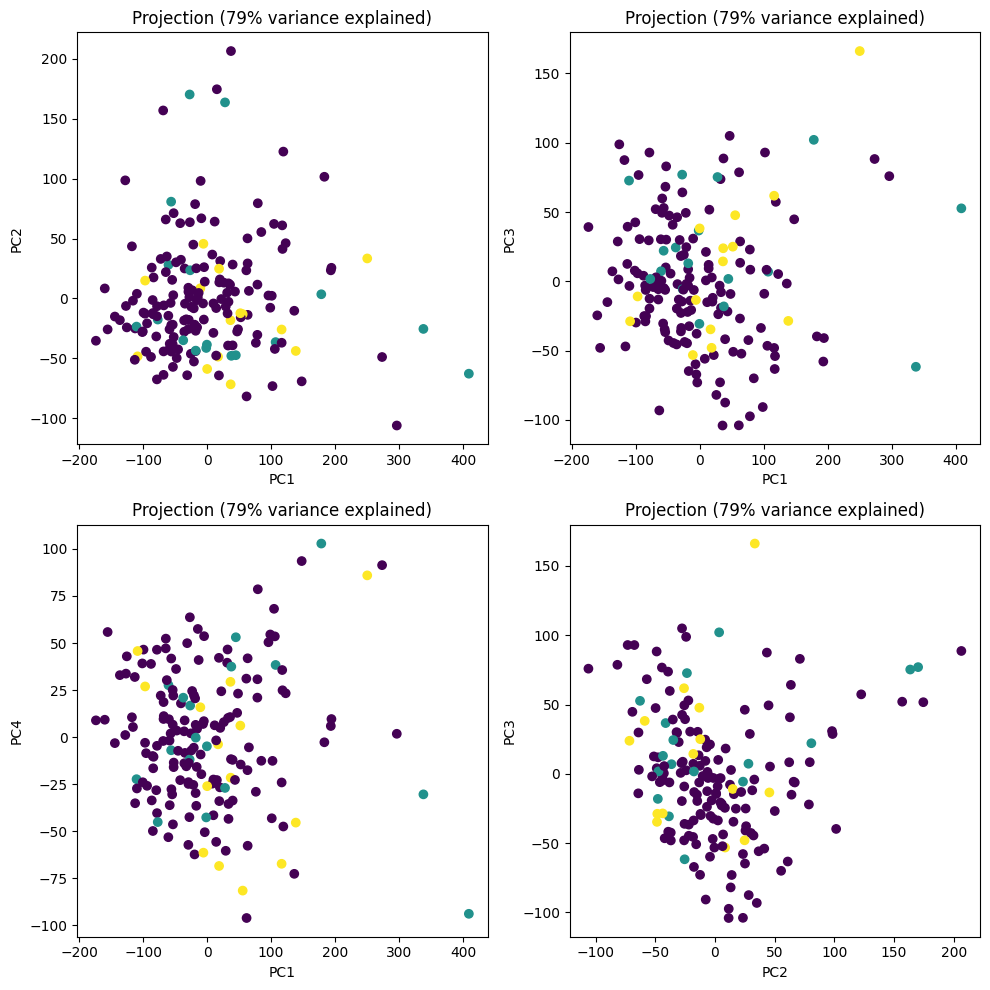

In [204]:
n_components=50

scaled_data = Frame.scale_data()
transformed_data, expl_variance_ratio = Frame.perform_pca(n_components)

principalDf = pd.DataFrame(data=transformed_data[:, :4], columns=['PC1', 'PC2', 'PC3', 'PC4'])

annotations = SampleAnnotation()
annotations.collect_annotations()

sample_groups = annotations.get_df()['sample group']

group_codes = pd.Categorical(sample_groups).codes

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].scatter(principalDf['PC1'], principalDf['PC2'], c=group_codes)
axes[0, 0].set_title("Projection ({}% variance explained)".format(int(sum(expl_variance_ratio*100))))
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

axes[0, 1].scatter(principalDf['PC1'], principalDf['PC3'], c=group_codes)
axes[0, 1].set_title("Projection ({}% variance explained)".format(int(sum(expl_variance_ratio*100))))
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC3')

axes[1, 0].scatter(principalDf['PC1'], principalDf['PC4'], c=group_codes)
axes[1, 0].set_title("Projection ({}% variance explained)".format(int(sum(expl_variance_ratio*100))))
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC4')

axes[1, 1].scatter(principalDf['PC2'], principalDf['PC3'], c=group_codes)
axes[1, 1].set_title("Projection ({}% variance explained)".format(int(sum(expl_variance_ratio*100))))
axes[1, 1].set_xlabel('PC2')
axes[1, 1].set_ylabel('PC3')

plt.tight_layout()
plt.show()


# Step 4: tSNE and UMAP

Another (more recent) good vizualization tool for high dimensional data is the t-SNE, and it's little brother, the UMAP. The advantage of this two methods is that they can reduce the dimension of your data using a desired number of of component (2 most of the time), not leaving alway a part of your data variability (in theory). On the other hand, they do not preserve large distance interpretation, so that only "local similarities" must be interpreted (e.g., outliers are much more difficult to spot). UMAP tends to preserve much better large distances, but still not reach the PCA in this topic.

Try to implement a t-SNE and/or a UMAP. UMAP can be implemented using the "umap" module, whereas t-SNE has a scikit-learn implementation.

Compare this visualition vs the PCA one.

In [ ]:
#Data Normalisation
df_norm = (Frame.df - Frame.df.min()) / (Frame.df.max() - Frame.df.min())
df_norm.fillna(gen_mean_dict, inplace=True)

df_norm.head()


,"""A1BG""","""A1BG-AS1""","""A1CF""","""A2M""","""A2M-AS1""","""A2ML1""","""A2MP1""","""A3GALT2""","""A4GALT""","""A4GNT""",...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533311_CGND-HRA-00350_counts,0.137097,0.165563,0.0,0.177366,0.275510,0.314168,0.15,0.000000,0.026906,0.0,...,0.285807,0.215000,0.267886,0.219599,0.287805,0.241758,0.219178,0.334963,0.175570,0.232463
GSM3533394_CGND-HRA-01236_counts,0.419355,0.450331,0.0,0.474022,0.321429,0.244353,0.15,0.214286,0.632287,0.0,...,0.285807,0.339722,0.346166,0.362456,0.239024,0.347652,0.264840,0.361858,0.319628,0.376219
GSM3533310_CGND-HRA-00338_counts,0.153226,0.162252,0.0,0.109286,0.280612,0.197125,0.15,0.142857,0.156951,0.2,...,0.339193,0.319444,0.303497,0.243211,0.307317,0.255744,0.406393,0.261614,0.289616,0.361120
GSM3533352_CGND-HRA-00546_counts,0.048387,0.311258,0.0,0.138400,0.270408,0.392197,0.20,0.214286,0.130045,0.2,...,0.366536,0.305000,0.316971,0.325266,0.253659,0.259740,0.264840,0.350856,0.327131,0.332494
GSM3533279_CGND-HRA-00226_counts,0.225806,0.145695,0.0,0.291430,0.459184,0.275154,0.30,0.142857,0.058296,0.2,...,0.525391,0.451944,0.474174,0.428571,0.478049,0.375624,0.319635,0.471883,0.442077,0.537590


## t-SNE

In [ ]:
X = df_norm[df_norm.columns]

In [ ]:
#In research of the best hyperparams

# param_grid = {'perplexity': [5, 10, 20, 30, 40],
#               'learning_rate': [10, 50, 100, 200, 500]}

# tsne = TSNE(n_components=2, verbose=1, n_iter=1000)
# grid_search = GridSearchCV(tsne, param_grid, cv=5, scoring='f1')
# grid_search.fit(X)
# print(grid_search.best_params_)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 176 samples in 0.022s...
[t-SNE] Computed neighbors for 176 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 176 / 176
[t-SNE] Mean sigma: 5.441375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.161041
[t-SNE] KL divergence after 1000 iterations: 0.866086


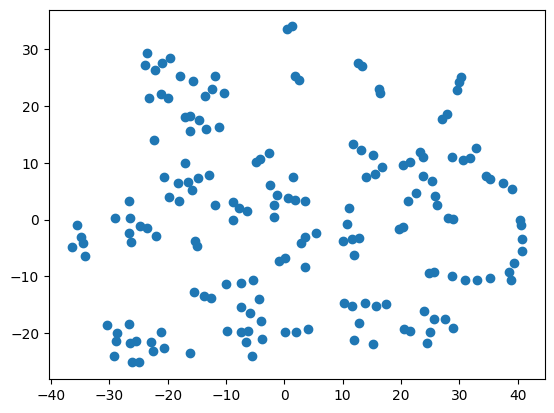

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=10)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

## UMAP

In [ ]:
#In research of the best hyperparams
# n_neighbors = [5,10,15]
# min_dist = [0.1,0.5,1]
# metric = ['euclidean', 'manhattan']

# for n in n_neighbors:
#     for d in min_dist:
#         for m in metric:
#             print(n,d,m)
#             umap_obj = umap.UMAP(n_neighbors=n, min_dist=d, metric=m)
#             umap_result = umap_obj.fit_transform(X)
#             plt.scatter(umap_result[:,0], umap_result[:,1])
#             plt.title('UMAP Projection')
#             plt.xlabel('UMAP 1')
#             plt.ylabel('UMAP 2')
#             plt.show()

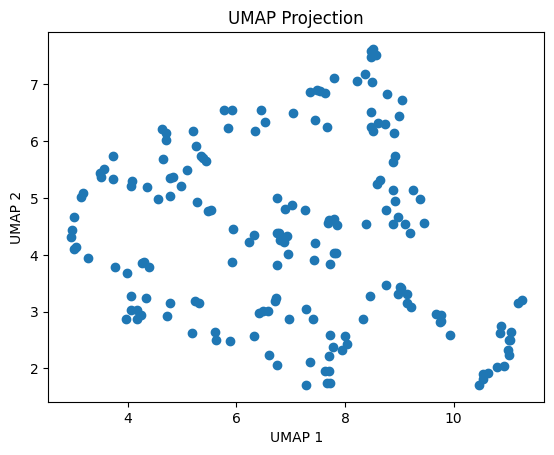

In [ ]:
umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean')
umap_result = umap_obj.fit_transform(X)
plt.scatter(umap_result[:,0], umap_result[:,1])
plt.title('UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


# Step 5 - Univariate analysis

## T-test implementation

In [ ]:
first_gene = Frame.df.iloc[:,0] # with data_matrix a dataframe containing the RNA count, with samples in row and genes in column 
first_gene.head()

GSM3533311_CGND-HRA-00350_counts    27
GSM3533394_CGND-HRA-01236_counts    62
GSM3533310_CGND-HRA-00338_counts    29
GSM3533352_CGND-HRA-00546_counts    16
GSM3533279_CGND-HRA-00226_counts    38
Name: "A1BG", dtype: int64

In [ ]:
als_index = Annotations.df['sample group'] == "ALS Spectrum MND" # with data_annotation the dataframe containing the annotation
ctrl_index = Annotations.df['sample group'] == "Non-Neurological Control"
first_gene_als = first_gene[als_index.values]
first_gene_ctrl = first_gene[ctrl_index.values]

In [ ]:
from scipy.stats import ttest_ind
pvalue_first_gene = ttest_ind(first_gene_als, first_gene_ctrl).pvalue
print(pvalue_first_gene)

0.06130232204571177


## T-test for each gene

In [ ]:
pvalues = Frame.df.apply(lambda x: ttest_ind(x[als_index.values], x[ctrl_index.values]).pvalue)

In [ ]:
print(pvalues.head())
print(len(pvalues))
print(type(pvalues))

"A1BG"        0.061302
"A1BG-AS1"    0.050313
"A1CF"        0.466465
"A2M"         0.308971
"A2M-AS1"     0.065283
dtype: float64
28953
<class 'pandas.core.series.Series'>


## Multiple testing

In [ ]:
from statsmodels.stats.multitest import multipletests

# Correction des valeurs p à l'aide de la méthode FDR-BH
pvalues.fillna(1, inplace=True)
rejected, pvals_corrected,_,_= multipletests(pvalues, method='fdr_bh')

print(pvals_corrected[:10])
print(len(pvalues), len(pvals_corrected))


[0.23768432 0.21855715 0.68347941 0.5433782  0.24430346 0.26889511
 0.26783269 0.26359511 0.72345715 0.64468091]
28953 28953


## Graphical representation

P-values are computed using 3 factors:

the difference in mean
the standard deviation(s)
the number of samples in each groups
The first factor (difference in mean) is what we can call the "effect". The two other factors will determine some kind of confidence for the first factor (how much the effect is trustable). So we can have huge effects with relatively high p-values, and small effect with low p-values. In biology, we always look at big and significant effect first (i.e., big difference, low p-value). A good way to report results is to use the volcano plot.

/tmp/ipykernel_10048/2536212221.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  fold_changes = Frame.df.apply(lambda x: np.log2(x[als_index.values].mean() / x[ctrl_index.values].mean()))
/tmp/ipykernel_10048/2536212221.py:3: RuntimeWarning: invalid value encountered in double_scalars
  fold_changes = Frame.df.apply(lambda x: np.log2(x[als_index.values].mean() / x[ctrl_index.values].mean()))
/tmp/ipykernel_10048/2536212221.py:3: RuntimeWarning: divide by zero encountered in log2
  fold_changes = Frame.df.apply(lambda x: np.log2(x[als_index.values].mean() / x[ctrl_index.values].mean()))


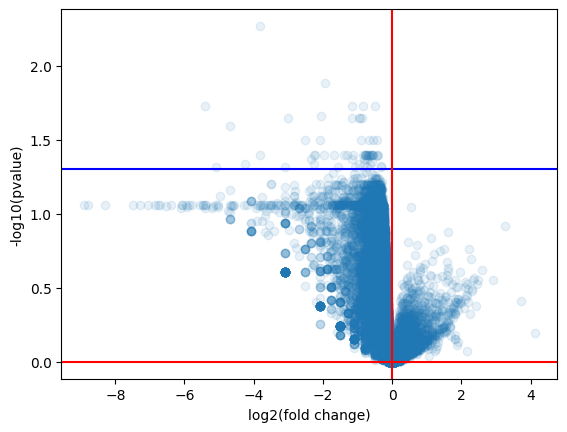

In [ ]:
#Volcano plot p-values vs fold change

fold_changes = Frame.df.apply(lambda x: np.log2(x[als_index.values].mean() / x[ctrl_index.values].mean()))

plt.scatter(fold_changes, -np.log10(pvals_corrected), alpha=0.1)
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')
plt.axvline(x=0, color='r', linestyle='-')

plt.xlabel('log2(fold change)')
plt.ylabel('-log10(pvalue)')
plt.show()


# Step 6 - Multivariate analysis